In [1]:
import math
import itertools
import os
from pathlib import Path
import sys
sys.path.insert(0,'../src/')
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from experiment import preliminary_setup

In [2]:
KWARGS = preliminary_setup()
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
register_matplotlib_converters()
FIGURES_DIRECTORY = KWARGS['figure_directory']
GRID = pd.read_csv(Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/buildsys_2022/data/misc/hyperparameter_design_1_grid.csv'))
SIMULATION_IDS = GRID['simulation_id'].unique()
RESULT_SUMMARY = pd.read_csv(Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/buildsys_2022/data/summary/hyperparameter_design_1_brief.csv'))
RESULT_SUMMARY = GRID.merge(RESULT_SUMMARY, on='simulation_id', how='left')
RESULT_SUMMARY = RESULT_SUMMARY.groupby([
    'group', 'discount', 'tau', 'lr', 'alpha', 'buildings', 'experiment', 'episode', 'building_id', 'building_name',
])[[
    'reward_sum', 'reward_mean',
    'net_electricity_consumption_sum',
    'net_electricity_consumption_emission_sum',
    'net_electricity_consumption_price_sum',
    'net_electricity_consumption_without_storage_sum',
    'net_electricity_consumption_emission_without_storage_sum',
    'net_electricity_consumption_price_without_storage_sum'
]].mean().reset_index()

# Building reward trajectory

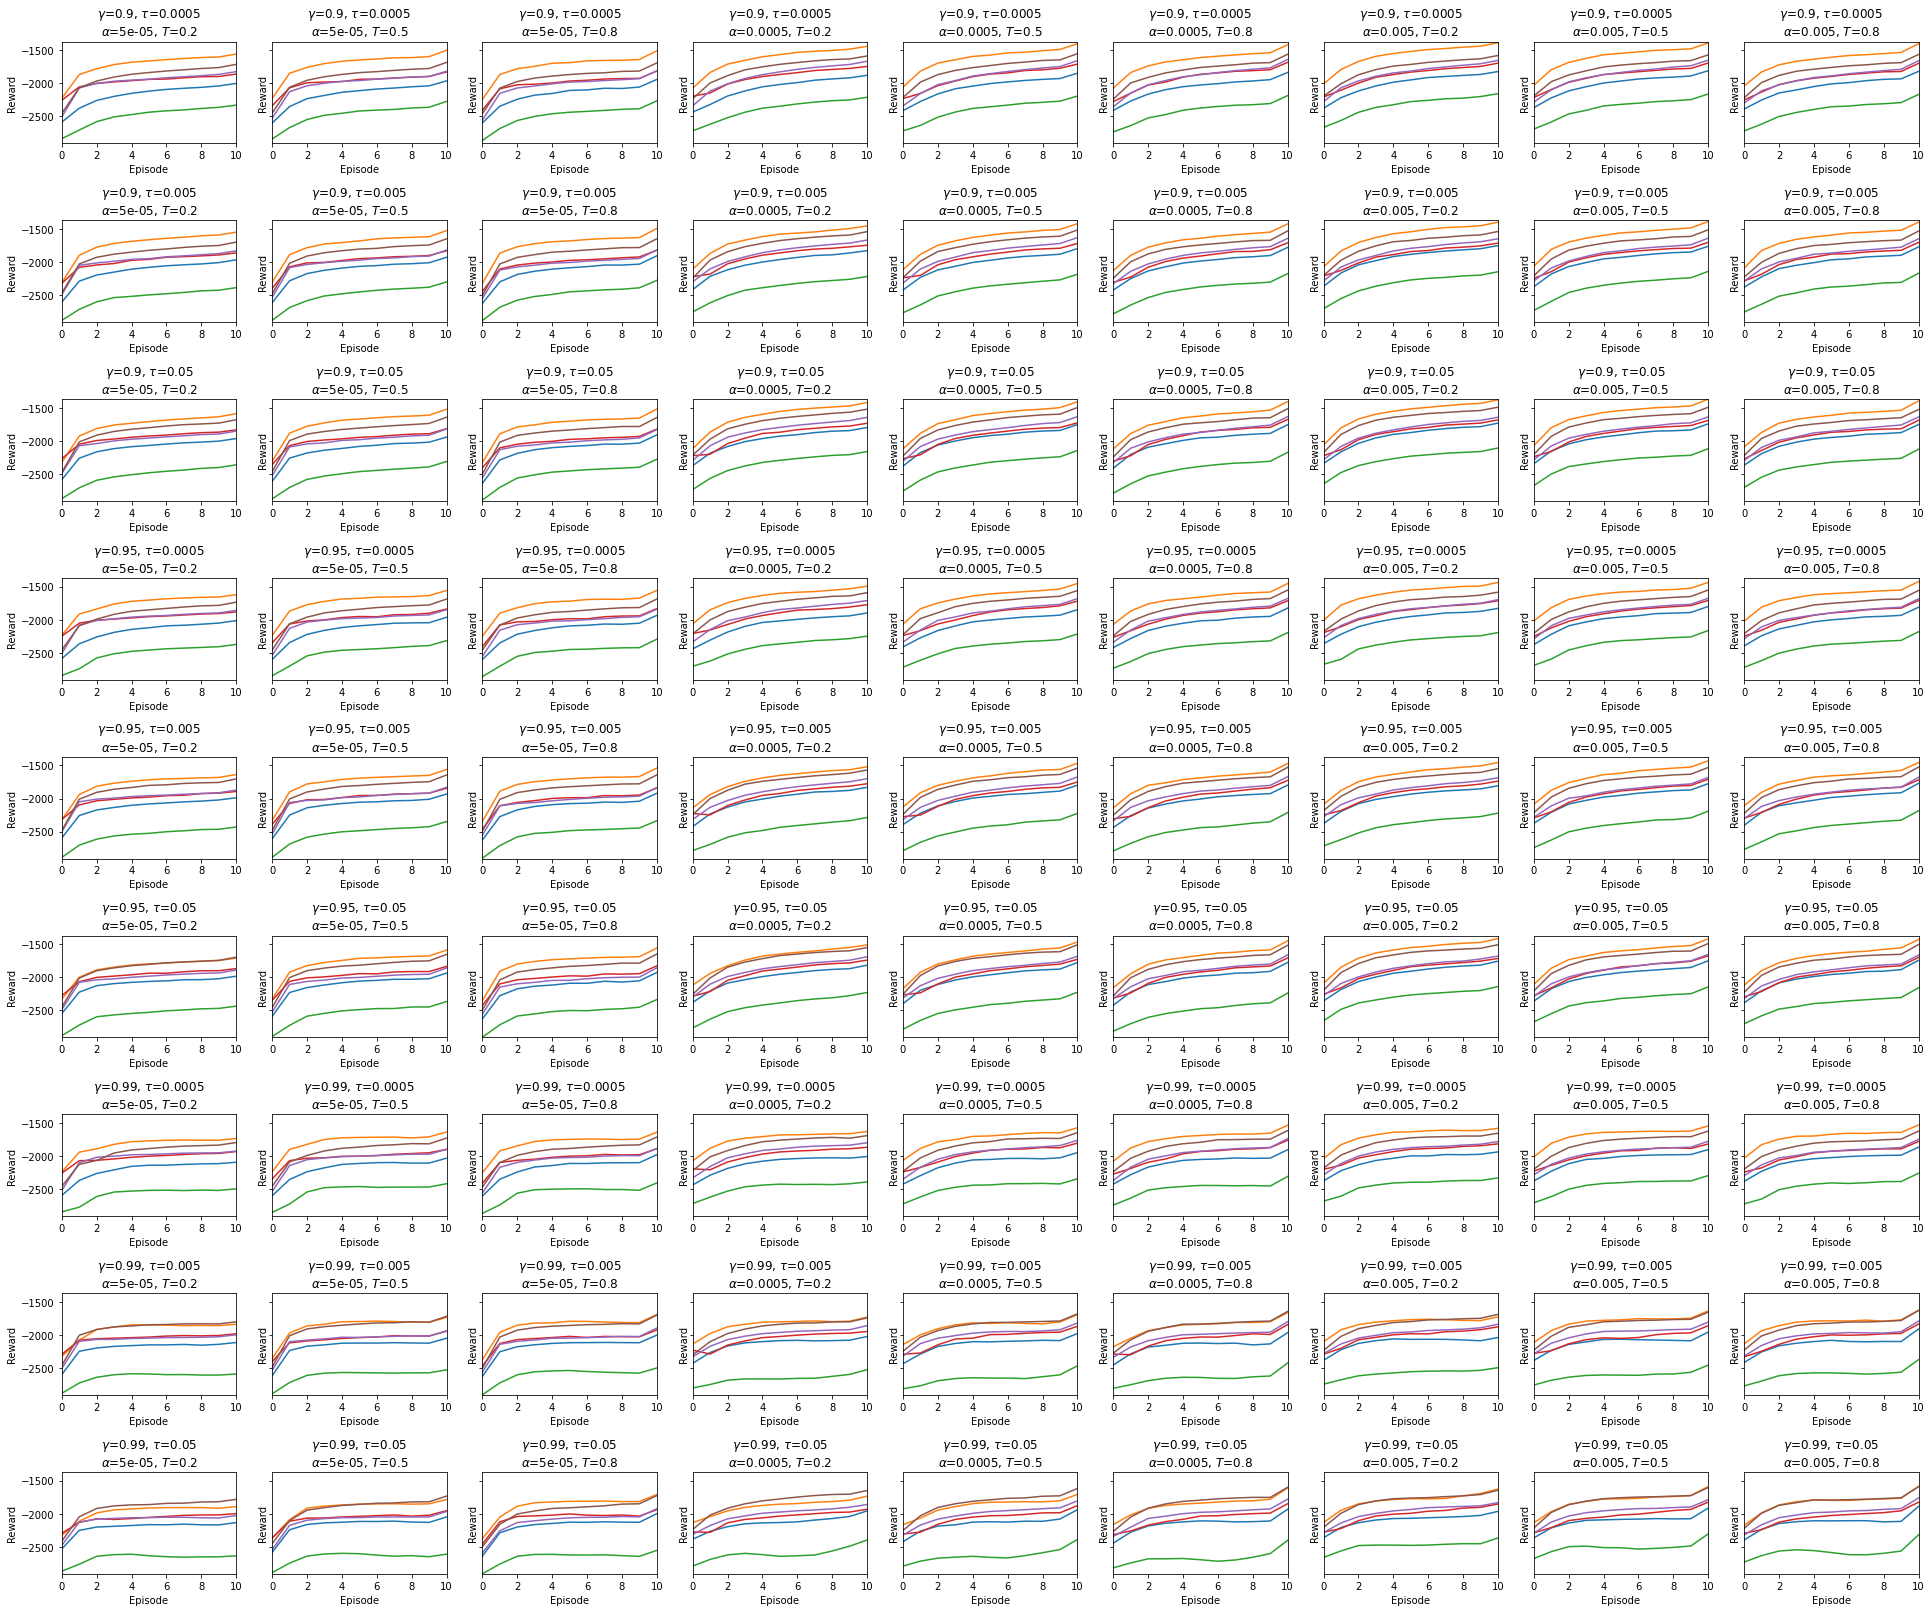

In [3]:
column_count_limit = 9
hyperparameters = RESULT_SUMMARY[['discount', 'tau', 'lr', 'alpha']].drop_duplicates()
row_count = math.ceil(len(hyperparameters)/column_count_limit)
column_count = min(column_count_limit, len(hyperparameters))
fig, _ = plt.subplots(row_count, column_count, figsize=(column_count*3, row_count*2.5), sharey=True)

for i, (ax, ((d, t, l, a), h_data)) in enumerate(zip(fig.axes, RESULT_SUMMARY.groupby(['discount', 'tau', 'lr', 'alpha']))):
    for j, (b, b_data) in enumerate(h_data.groupby('building_name')):
        x, y = b_data['episode'], b_data['reward_sum']
        ax.plot(x, y, label=b)
    
    ax.set_title(r'$\gamma$=' + str(d) + r', $\tau$=' + str(t) + '\n' + r'$\alpha$=' + str(l) + r', $T$=' + str(a))
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')

plt.tight_layout()
plt.show()

# Hyperparameter Combination Scatter

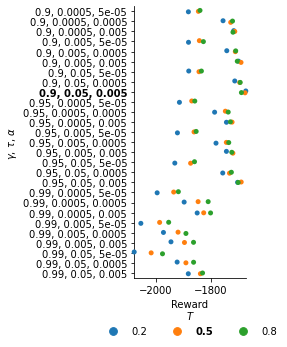

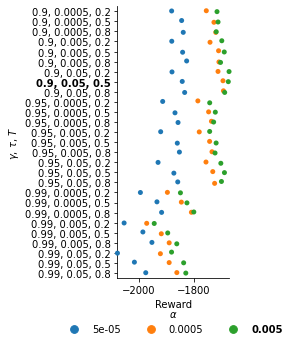

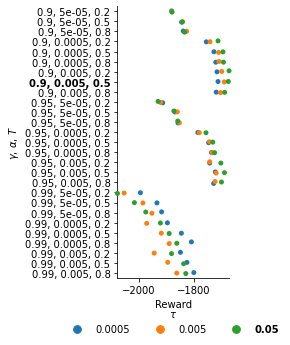

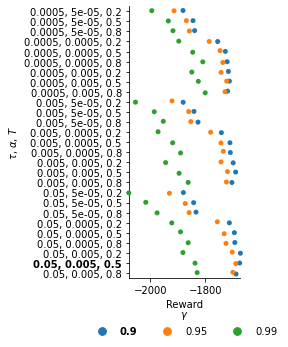

In [4]:
combinations = itertools.combinations(['discount', 'tau', 'lr', 'alpha'], 3)
combinations = [c for c in combinations]
row_count = 1
column_count = 1
plot_data = RESULT_SUMMARY[RESULT_SUMMARY['episode'] == RESULT_SUMMARY['episode'].max()].copy()
label_dict = {
    'discount': {'name': 'Discount factor', 'symbol': r'$\gamma$', 'optimal': 0.9},
    'tau': {'name': 'Decay rate', 'symbol': r'$\tau$', 'optimal': 0.05},
    'lr': {'name': 'Learning rate', 'symbol': r'$\alpha$', 'optimal': 0.005},
    'alpha': {'name': 'Temperature', 'symbol': r'$T$', 'optimal': 0.5},
}

for i, c in enumerate(combinations):
    l = [c_ for c_ in ['discount', 'tau', 'lr', 'alpha'] if c_ not in c][0]
    c_data = plot_data.groupby(list(c) + [l])[['reward_sum']].mean().reset_index()
    c_data['label'] = c_data.apply(lambda x: str(', '.join([str(x[c_]) for c_ in c])), axis=1)
    fig, ax = plt.subplots(row_count, column_count, figsize=(column_count*2.0, row_count*5.0))
    sns.stripplot(y='label', x='reward_sum', data=c_data, hue=l, ax=ax, clip_on=False)
    ax.set_ylabel(', '.join([label_dict[c_]["symbol"] for c_ in c]))
    ax.set_xlabel('Reward')
    ax.tick_params('x',which='both',rotation=0)

    for t in ax.get_yticklabels():
        if t.get_text() == ', '.join([str(label_dict[c_]["optimal"]) for c_ in c]):
            t.set_fontweight('heavy')
        else:
            pass
    
    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    ax.legend(
        title=label_dict[l]['symbol'],
        bbox_to_anchor=(0.5, -0.08),
        loc='upper center',
        framealpha=0,
        ncol=3
    )

    for t in ax.get_legend().get_texts():
        if t.get_text() == str(label_dict[l]['optimal']):
            t.set_fontweight('heavy')
        else:
            pass
        
    plt.savefig(os.path.join(FIGURES_DIRECTORY,f'last_episode_hyperparameter_design_1_combination_constant_{l}_reward.pdf'),bbox_inches='tight',transparent=True)
    plt.show()

# Final Hyperparameter Selection

In [5]:
plot_data = RESULT_SUMMARY[RESULT_SUMMARY['episode'] == RESULT_SUMMARY['episode'].max()].copy()
plot_data = plot_data.pivot_table(index=['discount', 'tau', 'lr', 'alpha'], columns='building_name', values='reward_sum')
building_names = plot_data.columns
plot_data['average'] = plot_data.mean(axis=1)
plot_data = plot_data.round(1)
plot_data = plot_data.reset_index(drop=False)
plot_data = plot_data.sort_values('average', ascending=False)
display(plot_data.head(30))

for b in building_names:
    b_data = plot_data.sort_values(b, ascending=False).iloc[0]
    print(b, ':', b_data[['discount', 'tau', 'lr', 'alpha', b]].to_dict())

building_name,discount,tau,lr,alpha,Building_2,Building_3,Building_6,Building_7,Building_8,Building_9,average
24,0.90,0.0500,0.0050,0.2,-1731.7,-1380.3,-2107.4,-1682.5,-1642.0,-1491.4,-1672.5
25,0.90,0.0500,0.0050,0.5,-1742.7,-1370.5,-2117.5,-1690.9,-1637.8,-1492.4,-1675.3
26,0.90,0.0500,0.0050,0.8,-1753.1,-1396.6,-2125.6,-1688.7,-1639.8,-1526.9,-1688.4
52,0.95,0.0500,0.0050,0.5,-1750.4,-1420.5,-2144.8,-1675.6,-1655.0,-1489.4,-1689.3
16,0.90,0.0050,0.0050,0.5,-1760.6,-1387.7,-2139.9,-1701.4,-1638.1,-1512.2,-1690.0
23,0.90,0.0500,0.0005,0.8,-1755.4,-1407.1,-2172.8,-1675.4,-1633.4,-1513.3,-1692.9
22,0.90,0.0500,0.0005,0.5,-1754.0,-1409.2,-2145.6,-1727.6,-1634.2,-1497.0,-1694.6
15,0.90,0.0050,0.0050,0.2,-1750.5,-1397.4,-2145.5,-1713.9,-1648.4,-1538.1,-1699.0
53,0.95,0.0500,0.0050,0.8,-1743.1,-1429.5,-2158.5,-1699.9,-1665.1,-1505.0,-1700.2
51,0.95,0.0500,0.0050,0.2,-1756.6,-1415.4,-2138.7,-1715.6,-1679.7,-1508.7,-1702.4


Building_2 : {'discount': 0.9, 'tau': 0.05, 'lr': 0.005, 'alpha': 0.2, 'Building_2': -1731.7}
Building_3 : {'discount': 0.9, 'tau': 0.05, 'lr': 0.005, 'alpha': 0.5, 'Building_3': -1370.5}
Building_6 : {'discount': 0.9, 'tau': 0.05, 'lr': 0.005, 'alpha': 0.2, 'Building_6': -2107.4}
Building_7 : {'discount': 0.9, 'tau': 0.05, 'lr': 0.0005, 'alpha': 0.8, 'Building_7': -1675.4}
Building_8 : {'discount': 0.9, 'tau': 0.005, 'lr': 0.0005, 'alpha': 0.5, 'Building_8': -1630.0}
Building_9 : {'discount': 0.95, 'tau': 0.05, 'lr': 0.005, 'alpha': 0.5, 'Building_9': -1489.4}
